# Optimization WFA - Mutiple Linear Regression

## Mutiple Linear Regression with scikit-learn 

In [26]:
import sys
sys.path.append('../../')

In [27]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades

In [28]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from util.Save_result_return import save_to_csv

plt.style.use("seaborn-v0_8")

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use("seaborn-v0_8")

In [30]:
from backtesting import Strategy

In [31]:
import warnings
warnings.simplefilter("ignore")

## Getting the Data

In [32]:
XAUUSD = load_data()

In [33]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [34]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


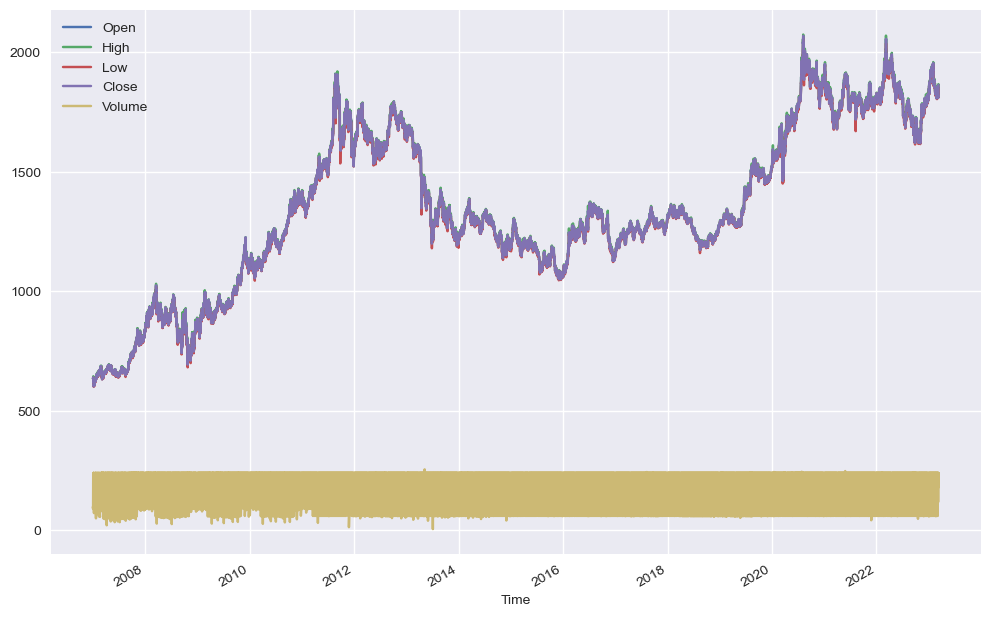

In [35]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [36]:
class Mutiple_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

In [37]:
mainFolder = 'Machine_Learning'
strategy = Mutiple_Regression
strategyName = 'Mutiple_Regression'
account_size = 1000
folder_ML_Strategy = 'Mutiple_Linear_Regression'
subFolder = 'Optimization'

In [38]:
class ML_Regression():

    def __init__(self, data, strategy, start_train,  end_train,  TF, window_size, account_size):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.end_train = end_train
        self.TF = TF
        self.window_size = window_size
        self.account_size = account_size
        self.data_train = None
        self.results = None
        self.model = None

    def Prepare(self, lags=5):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'] / data['Close'].shift(1))
        data.dropna(inplace=True)
        cols = []
        for lag in range(1, lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)
        data['pred'] = 0

        for i in range(self.window_size, len(data)):
            rolling_window_data = data.iloc[i - self.window_size :i ]

            lm = LinearRegression(fit_intercept=True)
            lm.fit(rolling_window_data[cols],
                   rolling_window_data['returns'])

            # Predict for the next data point
            pred_value = lm.predict(
                np.array(data[cols].iloc[i]).reshape(1, -1))
            data.at[data.index[i], 'pred'] = np.sign(pred_value[0])

        self.model = lm
        self.data_train = data.copy()

    def Backtest(self, data):
        # Assuming you have a Backtest class that performs backtesting
        account_size = self.account_size
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1/100)
        result = backtest.run()
        return result

    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)

        return result_train

## TF D1

In [39]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'D1'

### Window size 1 year

In [40]:
data = XAUUSD['D1']
window_size = 252
WFA = '1y'

In [41]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [42]:
test = ml.Run()

In [43]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-10 00:00:00
Duration                   5905 days 00:00:00
Exposure Time [%]                   33.869367
Equity Final [$]                          0.0
Equity Peak [$]                      1006.605
Return [%]                             -100.0
Buy & Hold Return [%]              206.029817
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]               62.011511
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                   -50.65485
Max. Drawdown Duration     5609 days 00:00:00
Avg. Drawdown Duration     2806 days 00:00:00
# Trades                                  713
Win Rate [%]                        48.948107
Best Trade [%]                       6.015035
Worst Trade [%]                     -9.971938
Avg. Trade [%]                    

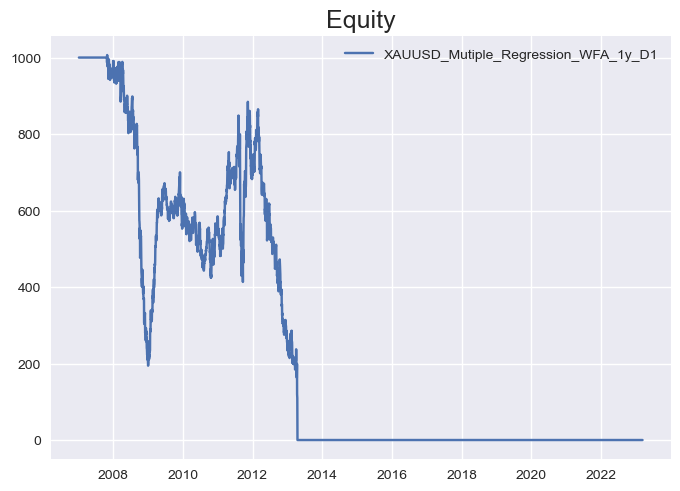

In [44]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [45]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [46]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [47]:
data = XAUUSD['D1']
window_size = 252 * 2
WFA = '2y'

In [48]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [49]:
test = ml.Run()

In [50]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-10 00:00:00
Duration                   5905 days 00:00:00
Exposure Time [%]                   89.974191
Equity Final [$]                     1777.352
Equity Peak [$]                      2185.755
Return [%]                            77.7352
Buy & Hold Return [%]              206.029817
Return (Ann.) [%]                    2.919131
Volatility (Ann.) [%]               20.744314
Sharpe Ratio                          0.14072
Sortino Ratio                        0.203635
Calmar Ratio                         0.052593
Max. Drawdown [%]                  -55.504583
Avg. Drawdown [%]                   -8.212485
Max. Drawdown Duration     1555 days 00:00:00
Avg. Drawdown Duration      146 days 00:00:00
# Trades                                 1808
Win Rate [%]                        51.327434
Best Trade [%]                      13.739498
Worst Trade [%]                    -10.144513
Avg. Trade [%]                    

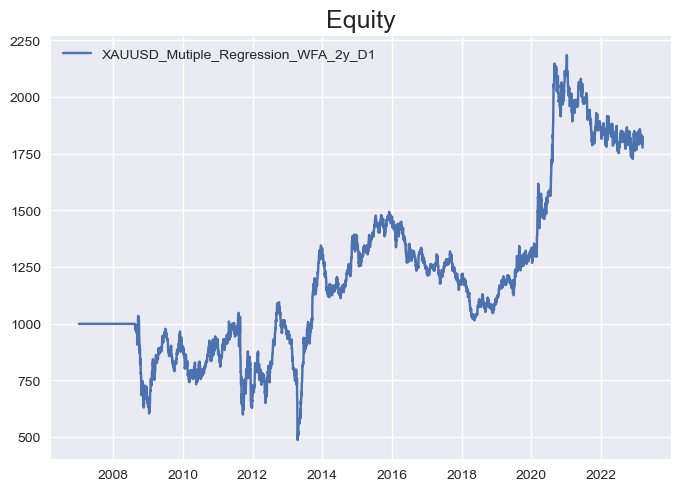

In [51]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [52]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [53]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [54]:
data = XAUUSD['D1']
window_size = 252 * 3
WFA = '3y'

In [55]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [56]:
test = ml.Run()

In [57]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-10 00:00:00
Duration                   5905 days 00:00:00
Exposure Time [%]                   84.971213
Equity Final [$]                      905.139
Equity Peak [$]                      1637.848
Return [%]                            -9.4861
Buy & Hold Return [%]              206.029817
Return (Ann.) [%]                   -0.497389
Volatility (Ann.) [%]               18.829635
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -57.045403
Avg. Drawdown [%]                   -6.809786
Max. Drawdown Duration     3381 days 00:00:00
Avg. Drawdown Duration      200 days 00:00:00
# Trades                                 1594
Win Rate [%]                        49.121706
Best Trade [%]                       7.501121
Worst Trade [%]                    -10.204268
Avg. Trade [%]                    

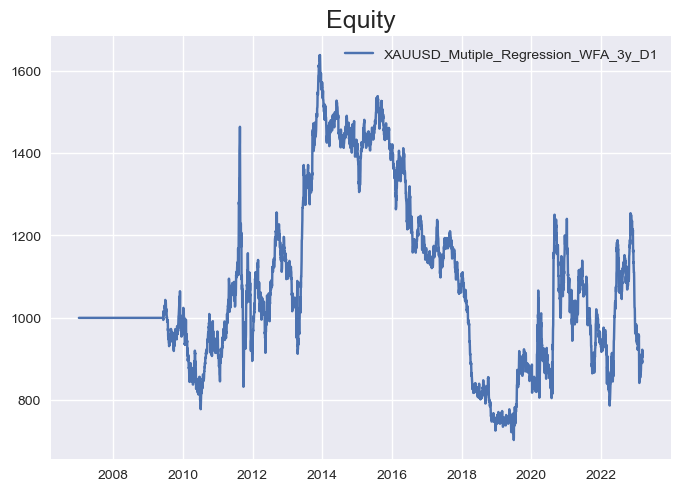

In [58]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [59]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [60]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [61]:
data = XAUUSD['D1']
window_size = 252 * 4
WFA = '4y'

In [62]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [63]:
test = ml.Run()

In [64]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-10 00:00:00
Duration                   5905 days 00:00:00
Exposure Time [%]                   79.968235
Equity Final [$]                      926.327
Equity Peak [$]                       1647.05
Return [%]                            -7.3673
Buy & Hold Return [%]              206.029817
Return (Ann.) [%]                   -0.382136
Volatility (Ann.) [%]               17.302263
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -55.348168
Avg. Drawdown [%]                   -3.900268
Max. Drawdown Duration     2640 days 00:00:00
Avg. Drawdown Duration       86 days 00:00:00
# Trades                                 1496
Win Rate [%]                        48.863636
Best Trade [%]                       9.638703
Worst Trade [%]                    -12.134219
Avg. Trade [%]                    

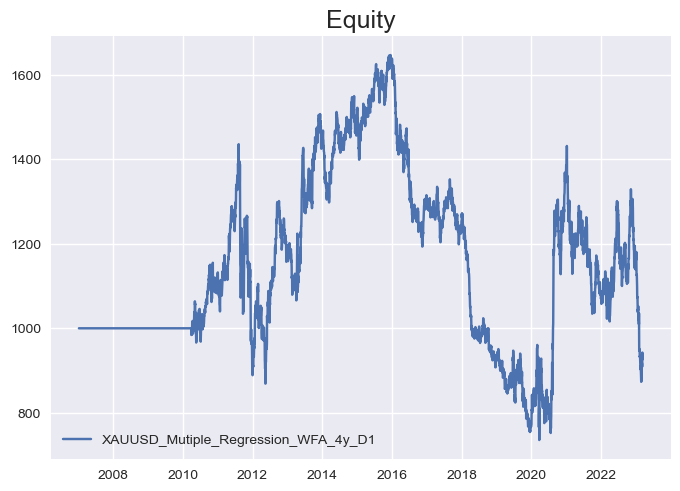

In [65]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [66]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [67]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [68]:
data = XAUUSD['D1']
window_size = 252 * 5
WFA = '5y'

In [69]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [70]:
test = ml.Run()

In [71]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-10 00:00:00
Duration                   5905 days 00:00:00
Exposure Time [%]                   74.965257
Equity Final [$]                     1194.447
Equity Peak [$]                      1747.244
Return [%]                            19.4447
Buy & Hold Return [%]              206.029817
Return (Ann.) [%]                    0.892909
Volatility (Ann.) [%]                15.09571
Sharpe Ratio                          0.05915
Sortino Ratio                        0.085123
Calmar Ratio                         0.016091
Max. Drawdown [%]                  -55.492822
Avg. Drawdown [%]                   -3.812474
Max. Drawdown Duration     3809 days 00:00:00
Avg. Drawdown Duration      107 days 00:00:00
# Trades                                 1444
Win Rate [%]                        49.584488
Best Trade [%]                      10.462506
Worst Trade [%]                    -11.718716
Avg. Trade [%]                    

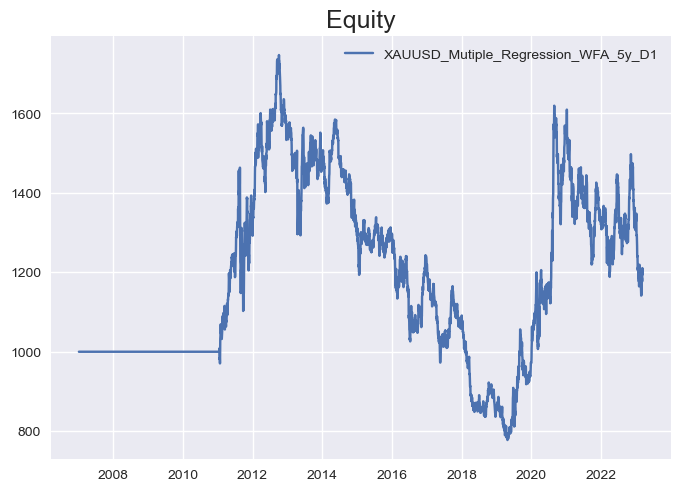

In [72]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [73]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [74]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [75]:
data = XAUUSD['D1']
window_size = 252 * 6
WFA = '6y'

In [76]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [77]:
test = ml.Run()

In [78]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-10 00:00:00
Duration                   5905 days 00:00:00
Exposure Time [%]                   64.721064
Equity Final [$]                       11.779
Equity Peak [$]                      1243.237
Return [%]                           -98.8221
Buy & Hold Return [%]              206.029817
Return (Ann.) [%]                   -19.92481
Volatility (Ann.) [%]              145.140209
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.271016
Avg. Drawdown [%]                  -12.349184
Max. Drawdown Duration     3802 days 00:00:00
Avg. Drawdown Duration      344 days 00:00:00
# Trades                                 1237
Win Rate [%]                         49.95958
Best Trade [%]                        6.35178
Worst Trade [%]                    -13.172487
Avg. Trade [%]                    

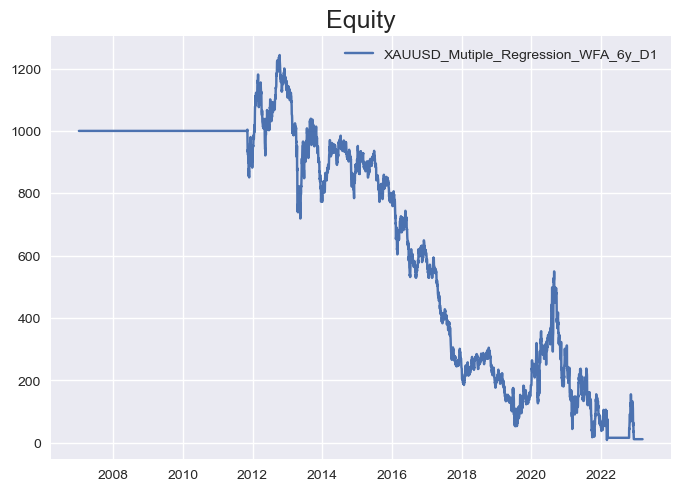

In [79]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [80]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [81]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [82]:
data = XAUUSD['D1']
window_size = 252 * 7
WFA = '7y'

In [83]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [84]:
test = ml.Run()

In [85]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-10 00:00:00
Duration                   5905 days 00:00:00
Exposure Time [%]                   34.703196
Equity Final [$]                       10.252
Equity Peak [$]                      1133.907
Return [%]                           -98.9748
Buy & Hold Return [%]              206.029817
Return (Ann.) [%]                  -20.479117
Volatility (Ann.) [%]               38.333314
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.145433
Avg. Drawdown [%]                  -25.816009
Max. Drawdown Duration     3809 days 00:00:00
Avg. Drawdown Duration      959 days 00:00:00
# Trades                                  642
Win Rate [%]                        50.778816
Best Trade [%]                       5.450626
Worst Trade [%]                     -8.495773
Avg. Trade [%]                    

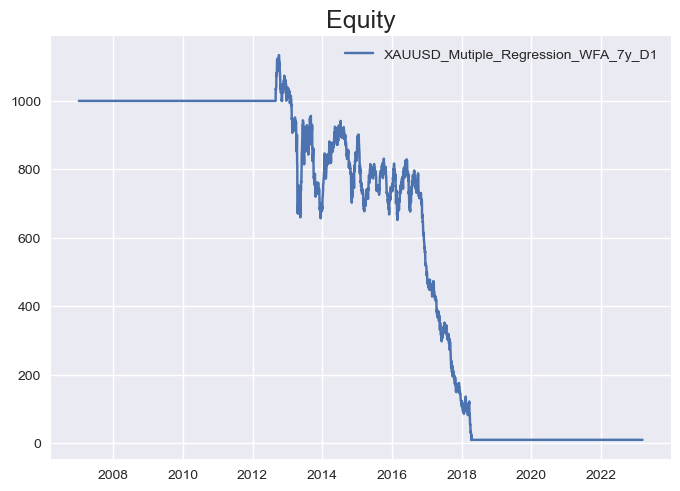

In [86]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [87]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [88]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [89]:
data = XAUUSD['D1']
window_size = 252 * 8
WFA = '8y'

In [90]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [91]:
test = ml.Run()

In [92]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-10 00:00:00
Duration                   5905 days 00:00:00
Exposure Time [%]                   45.840778
Equity Final [$]                       11.425
Equity Peak [$]                      1243.806
Return [%]                           -98.8575
Buy & Hold Return [%]              206.029817
Return (Ann.) [%]                  -20.046961
Volatility (Ann.) [%]               71.252559
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.802059
Avg. Drawdown [%]                  -13.707026
Max. Drawdown Duration     3459 days 00:00:00
Avg. Drawdown Duration      393 days 00:00:00
# Trades                                 1025
Win Rate [%]                        48.097561
Best Trade [%]                       5.450626
Worst Trade [%]                      -9.33197
Avg. Trade [%]                    

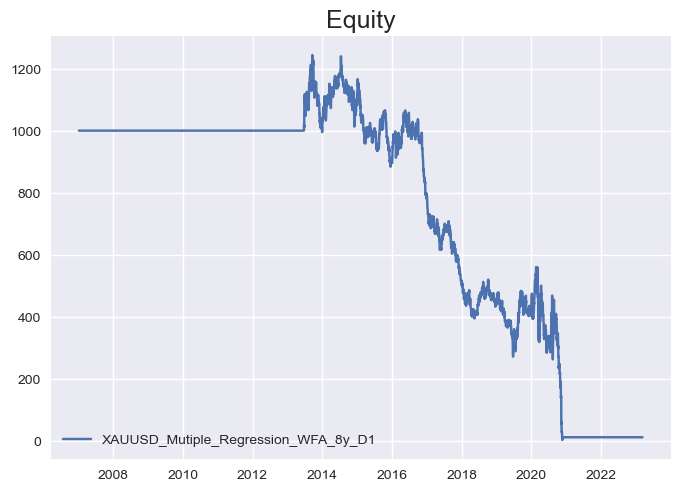

In [93]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [94]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [95]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H4

In [96]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'H4'

### Window size 1 year

In [97]:
data = XAUUSD['H4']
window_size = 252 * 6
WFA = '1y'

In [98]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [99]:
test = ml.Run()

In [100]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 16:00:00
Duration                   5911 days 16:00:00
Exposure Time [%]                   94.174047
Equity Final [$]                      464.877
Equity Peak [$]                      1911.447
Return [%]                           -53.5123
Buy & Hold Return [%]              192.490574
Return (Ann.) [%]                   -3.756036
Volatility (Ann.) [%]                18.68875
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -78.273109
Avg. Drawdown [%]                   -2.848721
Max. Drawdown Duration     3039 days 12:00:00
Avg. Drawdown Duration       53 days 08:00:00
# Trades                                10610
Win Rate [%]                        49.434496
Best Trade [%]                      11.025335
Worst Trade [%]                     -7.998057
Avg. Trade [%]                    

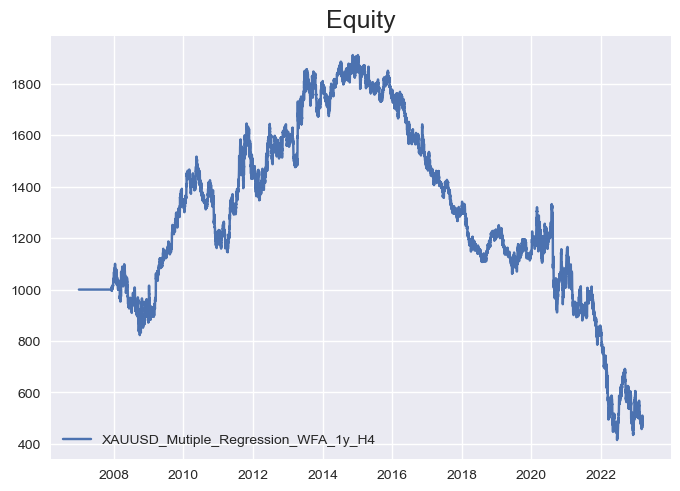

In [101]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [102]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [103]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [104]:
data = XAUUSD['H4']
window_size = 252 * 2 * 6
WFA = '2y'

In [105]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [106]:
test = ml.Run()

In [107]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 16:00:00
Duration                   5911 days 16:00:00
Exposure Time [%]                   88.351945
Equity Final [$]                     1280.055
Equity Peak [$]                      2032.635
Return [%]                            28.0055
Buy & Hold Return [%]              192.490574
Return (Ann.) [%]                    1.241671
Volatility (Ann.) [%]               14.833128
Sharpe Ratio                         0.083709
Sortino Ratio                        0.118956
Calmar Ratio                         0.020026
Max. Drawdown [%]                  -62.003409
Avg. Drawdown [%]                   -1.909587
Max. Drawdown Duration     3910 days 04:00:00
Avg. Drawdown Duration       42 days 07:00:00
# Trades                                10145
Win Rate [%]                        50.330212
Best Trade [%]                       7.768411
Worst Trade [%]                     -7.052948
Avg. Trade [%]                    

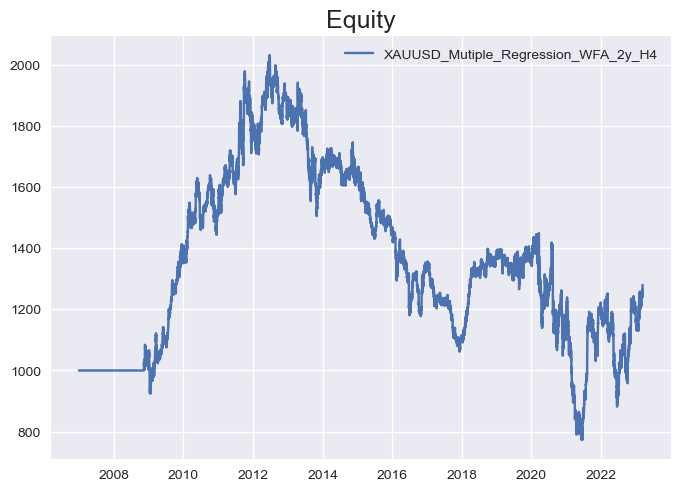

In [108]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [109]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [110]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [111]:
data = XAUUSD['H4']
window_size = 252 * 3 * 6
WFA = '3y'

In [112]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [113]:
test = ml.Run()

In [114]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 16:00:00
Duration                   5911 days 16:00:00
Exposure Time [%]                   82.529842
Equity Final [$]                     1084.075
Equity Peak [$]                      1730.949
Return [%]                             8.4075
Buy & Hold Return [%]              192.490574
Return (Ann.) [%]                     0.40429
Volatility (Ann.) [%]               16.558241
Sharpe Ratio                         0.024416
Sortino Ratio                        0.035268
Calmar Ratio                         0.006798
Max. Drawdown [%]                  -59.475987
Avg. Drawdown [%]                   -2.729422
Max. Drawdown Duration     3584 days 08:00:00
Avg. Drawdown Duration       60 days 23:00:00
# Trades                                 8845
Win Rate [%]                         50.17524
Best Trade [%]                       8.837434
Worst Trade [%]                     -7.052948
Avg. Trade [%]                    

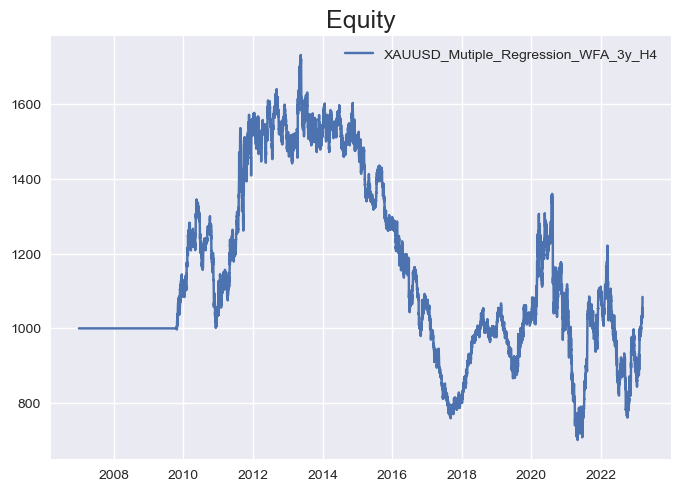

In [115]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [116]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [117]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [118]:
data = XAUUSD['H4']
window_size = 252 * 4 * 6
WFA = '4y'

In [119]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [120]:
test = ml.Run()

In [121]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 16:00:00
Duration                   5911 days 16:00:00
Exposure Time [%]                   64.347324
Equity Final [$]                          0.0
Equity Peak [$]                      1230.974
Return [%]                             -100.0
Buy & Hold Return [%]              192.490574
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]               49.504979
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                  -11.860228
Max. Drawdown Duration     4172 days 04:00:00
Avg. Drawdown Duration      324 days 15:00:00
# Trades                                 6616
Win Rate [%]                        50.075574
Best Trade [%]                       7.973015
Worst Trade [%]                     -7.052948
Avg. Trade [%]                    

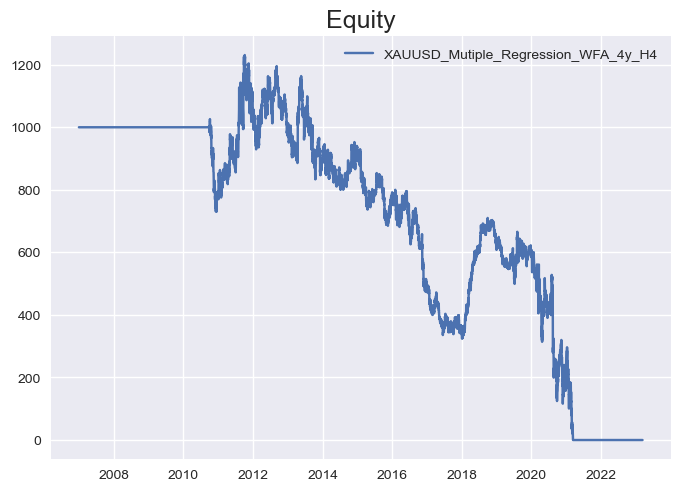

In [122]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [123]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [124]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [125]:
data = XAUUSD['H4']
window_size = 252 * 5 * 6
WFA = '5y'

In [126]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, 500)

In [127]:
test = ml.Run()

In [128]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 16:00:00
Duration                   5911 days 16:00:00
Exposure Time [%]                   13.138236
Equity Final [$]                        8.819
Equity Peak [$]                       695.998
Return [%]                           -98.2362
Buy & Hold Return [%]              192.490574
Return (Ann.) [%]                  -18.274564
Volatility (Ann.) [%]               30.223334
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -98.732899
Avg. Drawdown [%]                  -18.344154
Max. Drawdown Duration     3837 days 16:00:00
Avg. Drawdown Duration      420 days 07:00:00
# Trades                                 1174
Win Rate [%]                        48.637138
Best Trade [%]                       4.862823
Worst Trade [%]                     -4.253031
Avg. Trade [%]                    

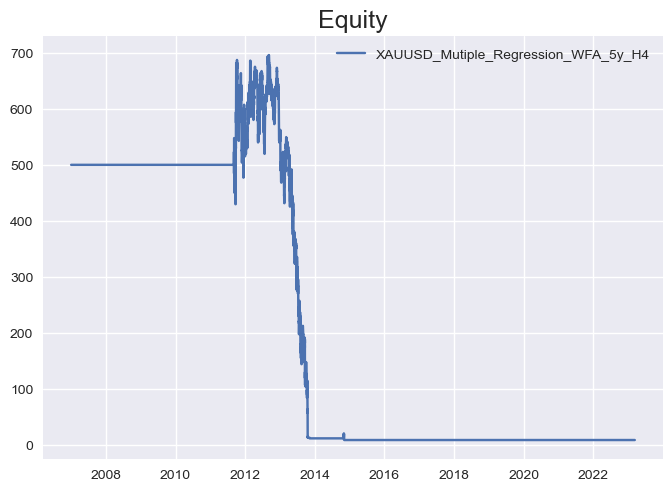

In [129]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [130]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [131]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [132]:
data = XAUUSD['H4']
window_size = 252 * 6 * 6
WFA = '6y'

In [133]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [134]:
test = ml.Run()

In [135]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 16:00:00
Duration                   5911 days 16:00:00
Exposure Time [%]                   52.764729
Equity Final [$]                          0.0
Equity Peak [$]                      1103.609
Return [%]                             -100.0
Buy & Hold Return [%]              192.490574
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]               85.351617
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                   -8.111398
Max. Drawdown Duration     3837 days 16:00:00
Avg. Drawdown Duration      296 days 19:00:00
# Trades                                 5466
Win Rate [%]                        50.823271
Best Trade [%]                       4.537772
Worst Trade [%]                     -4.875367
Avg. Trade [%]                    

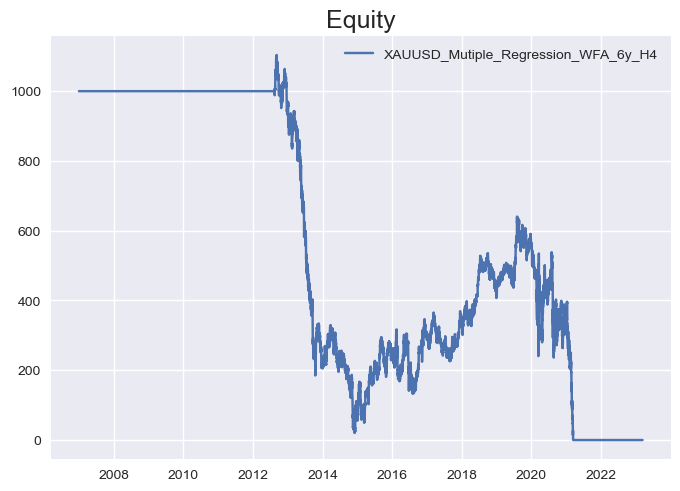

In [136]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [137]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [138]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [139]:
data = XAUUSD['H4']
window_size = 252 * 7 * 6
WFA = '7y'

In [140]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [141]:
test = ml.Run()

In [142]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 16:00:00
Duration                   5911 days 16:00:00
Exposure Time [%]                   59.241432
Equity Final [$]                     1065.032
Equity Peak [$]                      1527.584
Return [%]                             6.5032
Buy & Hold Return [%]              192.490574
Return (Ann.) [%]                    0.315396
Volatility (Ann.) [%]               15.897533
Sharpe Ratio                         0.019839
Sortino Ratio                         0.02879
Calmar Ratio                         0.005626
Max. Drawdown [%]                  -56.061336
Avg. Drawdown [%]                   -2.132728
Max. Drawdown Duration     2069 days 12:00:00
Avg. Drawdown Duration       38 days 22:00:00
# Trades                                 6396
Win Rate [%]                        51.297686
Best Trade [%]                       6.177515
Worst Trade [%]                     -4.541249
Avg. Trade [%]                    

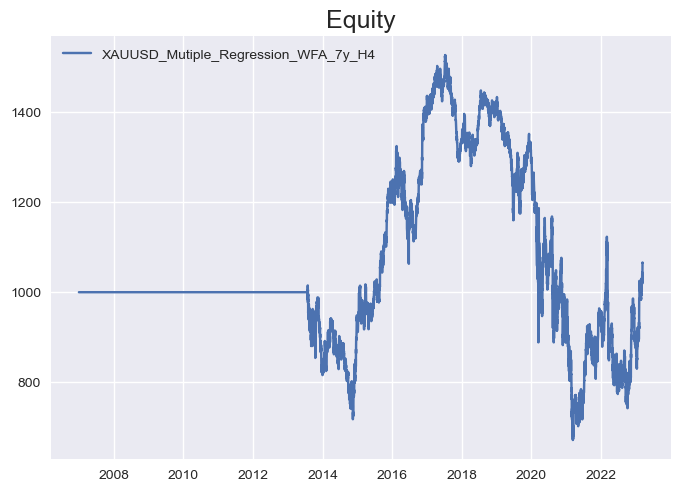

In [143]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [144]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [145]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [146]:
data = XAUUSD['H4']
window_size = 252 * 8 * 6
WFA = '8y'

In [147]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [148]:
test = ml.Run()

In [149]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 16:00:00
Duration                   5911 days 16:00:00
Exposure Time [%]                   48.428956
Equity Final [$]                       15.134
Equity Peak [$]                      1091.109
Return [%]                           -98.4866
Buy & Hold Return [%]              192.490574
Return (Ann.) [%]                  -18.897585
Volatility (Ann.) [%]               48.024368
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -98.612971
Avg. Drawdown [%]                  -11.651285
Max. Drawdown Duration     2200 days 12:00:00
Avg. Drawdown Duration      211 days 03:00:00
# Trades                                 5261
Win Rate [%]                        49.971488
Best Trade [%]                       4.447708
Worst Trade [%]                     -4.700015
Avg. Trade [%]                    

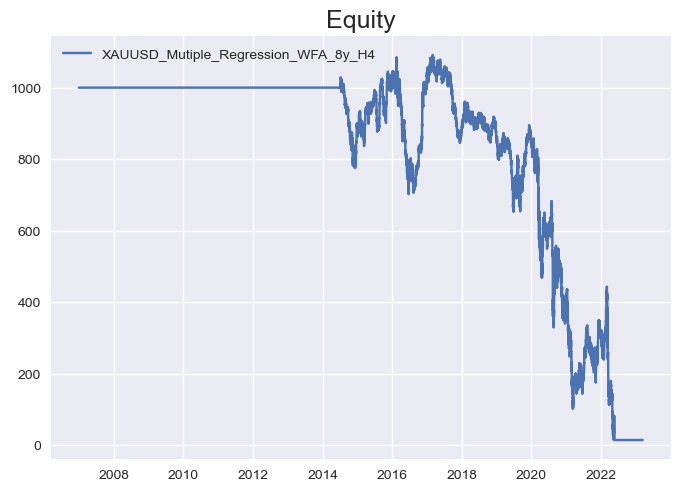

In [150]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [151]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [152]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H1

In [153]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'H1'

### Window size 1 year

In [154]:
data = XAUUSD['H1']
window_size = 252 * 24
WFA = '1y'

In [155]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [156]:
test = ml.Run()

In [157]:
test

Start                     2007-01-01 06:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 11:00:00
Exposure Time [%]                   93.824274
Equity Final [$]                       903.04
Equity Peak [$]                      1941.324
Return [%]                             -9.696
Buy & Hold Return [%]              193.241946
Return (Ann.) [%]                   -0.508342
Volatility (Ann.) [%]               18.526705
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -70.115189
Avg. Drawdown [%]                   -1.966639
Max. Drawdown Duration     3383 days 07:00:00
Avg. Drawdown Duration       33 days 16:00:00
# Trades                                42896
Win Rate [%]                          50.4779
Best Trade [%]                      10.587147
Worst Trade [%]                     -6.328868
Avg. Trade [%]                    

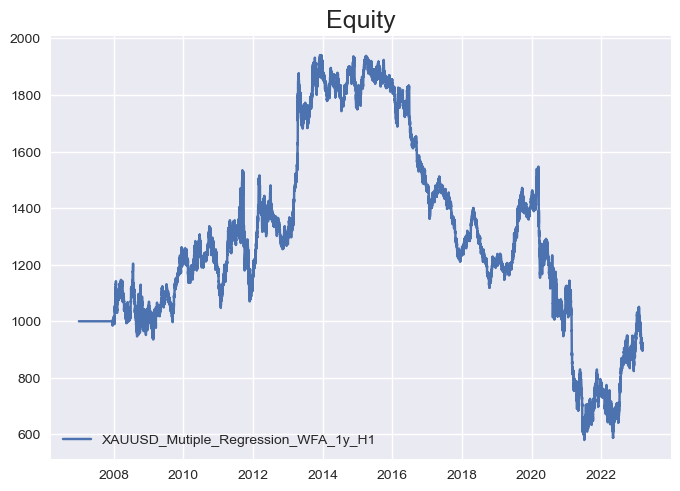

In [158]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [159]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [160]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [161]:
data = XAUUSD['H1']
window_size = 252 * 2 * 24
WFA = '2y'

In [162]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [163]:
test = ml.Run()

KeyboardInterrupt: 

In [ ]:
test

Start                     2007-01-01 06:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 10:00:00
Exposure Time [%]                   87.649443
Equity Final [$]                     3455.661
Equity Peak [$]                      3455.661
Return [%]                           245.5661
Buy & Hold Return [%]              191.844558
Return (Ann.) [%]                    6.392383
Volatility (Ann.) [%]                 9.56018
Sharpe Ratio                         0.668647
Sortino Ratio                        1.034088
Calmar Ratio                         0.338543
Max. Drawdown [%]                  -18.882055
Avg. Drawdown [%]                   -0.693125
Max. Drawdown Duration     1071 days 08:00:00
Avg. Drawdown Duration        9 days 08:00:00
# Trades                                23023
Win Rate [%]                        53.637667
Best Trade [%]                       4.426038
Worst Trade [%]                     -5.401112
Avg. Trade [%]                    

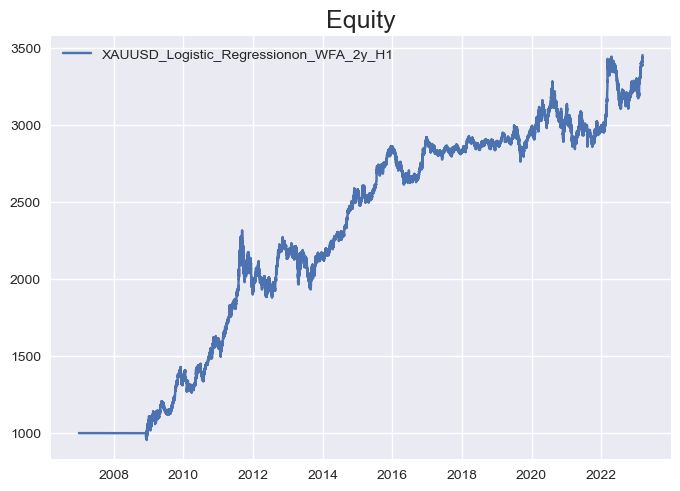

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 3 * 24
WFA = '3y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-01 06:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 10:00:00
Exposure Time [%]                   81.474675
Equity Final [$]                     2603.657
Equity Peak [$]                       2704.48
Return [%]                           160.3657
Buy & Hold Return [%]              191.844558
Return (Ann.) [%]                    4.897908
Volatility (Ann.) [%]               11.207171
Sharpe Ratio                         0.437033
Sortino Ratio                        0.652963
Calmar Ratio                         0.191909
Max. Drawdown [%]                  -25.521974
Avg. Drawdown [%]                   -0.895694
Max. Drawdown Duration     1303 days 04:00:00
Avg. Drawdown Duration       13 days 07:00:00
# Trades                                19828
Win Rate [%]                        54.120436
Best Trade [%]                       3.223874
Worst Trade [%]                     -7.328009
Avg. Trade [%]                    

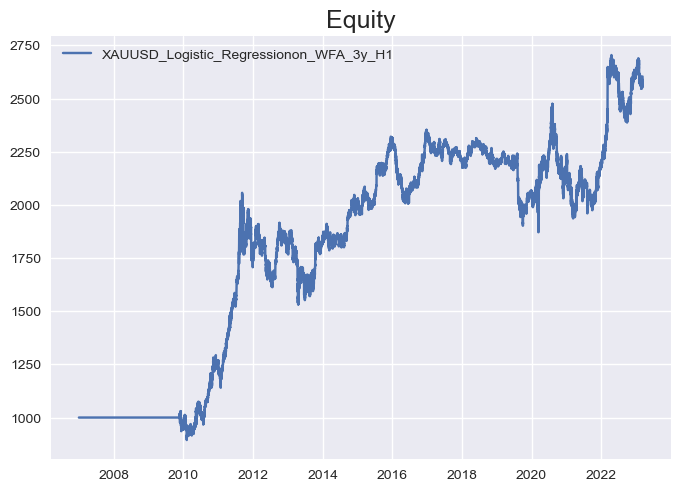

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 4 * 24
WFA = '4y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 5 * 24
WFA = '5y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 6 * 24
WFA = '6y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 7 * 24
WFA = '7y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 8 * 24
WFA = '8y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H30

In [ ]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'M30'

### Window size 1 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 48
WFA = '1y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 2 * 48
WFA = '2y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 3 * 48
WFA = '3y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 4 * 48
WFA = '4y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 5 * 48
WFA = '5y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 6 * 48
WFA = '6y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 7 * 48 
WFA = '7y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 8 * 48
WFA = '8y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')